## BECS 2 Data Challenge: Predicting Cancer Status of Patients
Koch Kilian (ZHAW), Rieder Jonathan (ZHAW), Yar Kevin (ZHAW)

The aim of this project work is to predict 6 different healt status of patients (healthy, breast-, lung-, pancreatic-, colorectal- and prostate cancer). The prediction is based on mass spectroscopy data of different protein levels meassured in patients blood. 

## Part 1: Loading packages and define initial Parameters

In [1]:
#import necessary packages 
import os
import random
import xgboost
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn_genetic import GAFeatureSelectionCV

os.getcwd()
"""
usage joblib
# save the model: 
joblib.dump(model , "model.pkl")
# load the model:
model = joblib.load("model.pkl")
"""

'\nusage joblib\n# save the model: \njoblib.dump(model , "model.pkl")\n# load the model:\nmodel = joblib.load("model.pkl")\n'

## Part 2: Data Preprocessing
In this section the raw data is preprocessed

In [ ]:
#Kilian insert your code here

## Part 3: Data Preparation
In this section the raw data is prepared and reshaped to be fed into the different models. Furhtermore, the distribution of the input data is visualized to check if the data set is balanced. The data is converted into two main variables X (patiens and the coresponding protein quantities) and y (patients and the coresponding healt condition). Furthermore the data will be filtered to reduce noise. In addition, further adjustments will be conductet to make the data suitable for model inputs.

In [2]:
#create pandas dataframe
#load data with protein quantities
path = "rawData/tidy.csv"

#load data for patients healt status
pathMet = "rawData/metadata.csv"
tidy = pd.read_csv(path, sep=",")
tidyMet = pd.read_csv(pathMet, sep=";", index_col=0)

#remove samples which are not in the metadata index column
tidy = tidy[ (tidy["R.FileName"].isin(tidyMet.index)) ]
tidyMer    = pd.merge(tidy, tidyMet, how="left", on="R.FileName")
tidySub = tidyMer[["R.FileName", "uniprot", "meanAbu", "Cancer"]]
tidySub.Cancer.value_counts()

Breast Cancer        84630
Lung Cancer          81900
Pancreatic Cancer    81900
Colorectal Cancer    81900
Healthy              81900
Prostate Cancer      81900
Name: Cancer, dtype: int64

In [3]:
#rank proteins by concentration
tidySub["Rank"] = tidySub.groupby(by=["R.FileName", "Cancer"])["meanAbu"].rank(ascending=False)
tidySub.head()

/var/folders/m3/y3ws5lg56t1_m9cdppylg_dh0000gn/T/ipykernel_793/2099945389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidySub["Rank"] = tidySub.groupby(by=["R.FileName", "Cancer"])["meanAbu"].rank(ascending=False)


,R.FileName,uniprot,meanAbu,Cancer,Rank
0,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6H9,11601.398438,Lung Cancer,1090.0
1,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I0,3827.466797,Lung Cancer,2497.0
2,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I1,114115.796875,Lung Cancer,468.0
3,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6I7,4293.524902,Lung Cancer,2325.0
4,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,A0A075B6J1,5969.785645,Lung Cancer,1538.0


### Data filtering

The dataset shows a high range of protien conentration. It is known that biomarker meassurements appear in the medium and low concentration range. Therefore, we introduce a protein concentraiton treshhold. ALl protein concentrattions higher then 10^7 and bellow 10^3.5 are removed from the dataset.

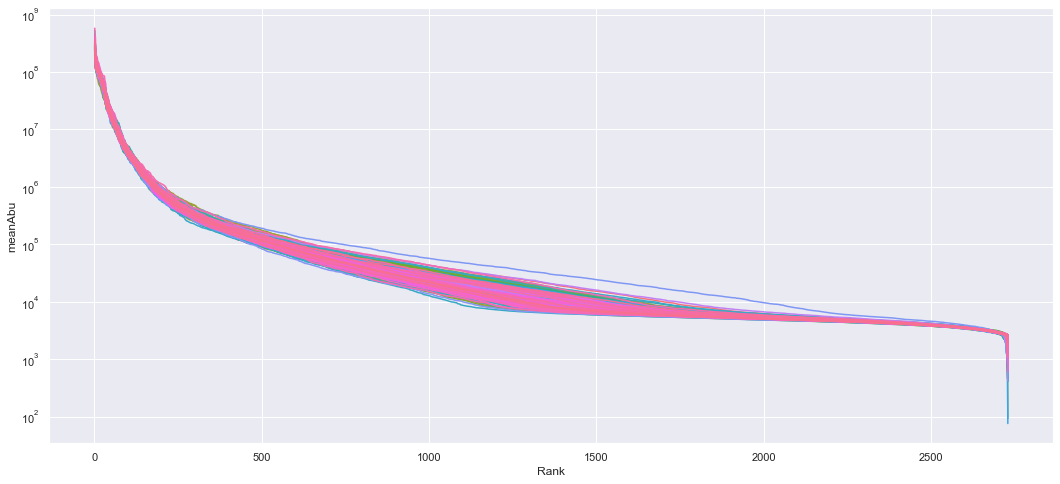

In [4]:
# With all proteins
sns.set(rc={'figure.figsize':(18,8)})
_ = sns.lineplot(x="Rank", y="meanAbu", hue="R.FileName", data=tidySub)
_.set_yscale("log")
_.legend_.remove()


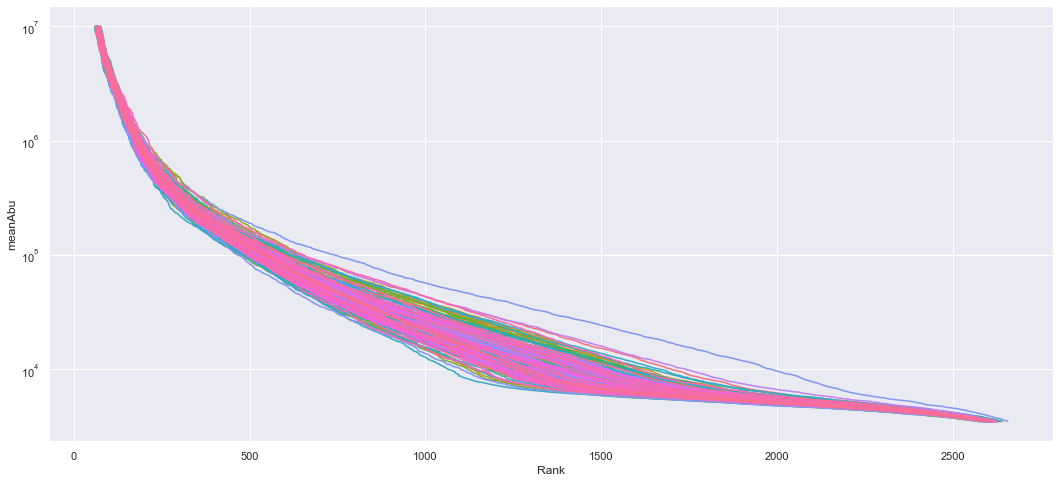

In [5]:
# With proteins in the range

tidySubFiltered = tidySub[ (tidySub.meanAbu <= 10000000) & (tidySub.meanAbu >=3500) ] 

sns.set(rc={'figure.figsize':(18,8)})
_ = sns.lineplot(x="Rank", y="meanAbu", hue="R.FileName", data=tidySubFiltered)
_.set_yscale("log")
_.legend_.remove()


In [6]:
#reshape data for model
#X data
tidyReshaped = tidySubFiltered.pivot(index = "R.FileName", columns = "uniprot", values = "meanAbu")
tidyReshaped.head()

uniprot,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y696,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7
R.FileName,,,,,,,,,,,,,,,,,,,,,
J_D201211_MDIA_P705_SExp01-BGSID-100_R01,14946.335938,44693.898438,5286.701172,NaN,6439.688965,4968.654297,9251.992188,40399.160156,7.631951e+04,50205.507812,...,21067.064453,46711.242188,4999.735352,3843.583496,3900.420654,4008.093262,30271.335938,5562199.50,20829.845703,186635.421875
J_D201211_MDIA_P705_SExp01-BGSID-101_R01,38555.570312,51684.972656,9045.169922,7985.143555,5580.953125,NaN,6626.406738,100954.500000,1.029116e+06,15354.227539,...,231849.765625,37423.011719,32570.783203,16396.248047,5583.424316,NaN,17626.980469,3184120.25,19085.271484,125766.781250
J_D201211_MDIA_P705_SExp01-BGSID-102_R01,4343.331543,46242.109375,7758.438477,6393.914551,NaN,NaN,7488.952148,15695.381836,4.025498e+04,70995.250000,...,43056.816406,42504.460938,5609.707031,5444.106445,4461.832520,5693.956543,24841.900391,2423431.00,5232.701660,163073.593750
J_D201211_MDIA_P705_SExp01-BGSID-103_R01,4416.617676,4498.669922,5079.411133,5620.907227,3928.547607,3783.535645,4335.171387,NaN,1.193392e+04,26160.638672,...,27962.792969,42933.371094,5125.121582,5866.069336,8054.897461,6311.884766,32395.267578,1822234.00,5621.607910,242902.843750
J_D201211_MDIA_P705_SExp01-BGSID-104_R01,35277.675781,43951.742188,9787.271484,5069.423340,3543.106445,5205.493652,4844.367676,19586.009766,1.528375e+05,58521.871094,...,28075.748047,34184.515625,5825.452637,6959.082520,7264.607422,5692.607422,25756.402344,3612022.00,6194.402832,74033.210938


In [7]:
#y condition
Group =  tidySubFiltered.drop(["uniprot", "meanAbu", "Rank"], axis=1)
Group = Group.drop_duplicates().reset_index(drop=True)
Group.head()

,R.FileName,Cancer
0,J_D201211_MDIA_P705_SExp01-BGSID-1_R01,Lung Cancer
1,J_D201211_MDIA_P705_SExp01-BGSID-10_R01,Lung Cancer
2,J_D201211_MDIA_P705_SExp01-BGSID-100_R01,Pancreatic Cancer
3,J_D201211_MDIA_P705_SExp01-BGSID-101_R01,Colorectal Cancer
4,J_D201211_MDIA_P705_SExp01-BGSID-102_R01,Lung Cancer


In [8]:
#merge X and y and set dataframe to numerical values
data = pd.merge(tidyReshaped, Group, how="left", on="R.FileName")
data = data.set_index("R.FileName")

In [9]:
X_ = data.iloc[:, :-1].apply(np.log2)
y_ = data.iloc[:,-1]

#check first 10 entries of the dataframe 
data[:10]

,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I7,A0A075B6J1,A0A075B6J9,A0A075B6K4,A0A075B6K5,A0A075B6P5;P01615,A0A075B6R2,...,Q9Y6C2,Q9Y6E0,Q9Y6E2,Q9Y6G9,Q9Y6L6,Q9Y6N7,Q9Y6R7,Q9Y6Y9,Q9Y6Z7,Cancer
R.FileName,,,,,,,,,,,,,,,,,,,,,
J_D201211_MDIA_P705_SExp01-BGSID-100_R01,14946.335938,44693.898438,5286.701172,NaN,6439.688965,4968.654297,9251.992188,40399.160156,7.631951e+04,50205.507812,...,46711.242188,4999.735352,3843.583496,3900.420654,4008.093262,30271.335938,5562199.50,20829.845703,186635.421875,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-101_R01,38555.570312,51684.972656,9045.169922,7985.143555,5580.953125,NaN,6626.406738,100954.500000,1.029116e+06,15354.227539,...,37423.011719,32570.783203,16396.248047,5583.424316,NaN,17626.980469,3184120.25,19085.271484,125766.781250,Colorectal Cancer
J_D201211_MDIA_P705_SExp01-BGSID-102_R01,4343.331543,46242.109375,7758.438477,6393.914551,NaN,NaN,7488.952148,15695.381836,4.025498e+04,70995.250000,...,42504.460938,5609.707031,5444.106445,4461.832520,5693.956543,24841.900391,2423431.00,5232.701660,163073.593750,Lung Cancer
J_D201211_MDIA_P705_SExp01-BGSID-103_R01,4416.617676,4498.669922,5079.411133,5620.907227,3928.547607,3783.535645,4335.171387,NaN,1.193392e+04,26160.638672,...,42933.371094,5125.121582,5866.069336,8054.897461,6311.884766,32395.267578,1822234.00,5621.607910,242902.843750,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-104_R01,35277.675781,43951.742188,9787.271484,5069.423340,3543.106445,5205.493652,4844.367676,19586.009766,1.528375e+05,58521.871094,...,34184.515625,5825.452637,6959.082520,7264.607422,5692.607422,25756.402344,3612022.00,6194.402832,74033.210938,Breast Cancer
J_D201211_MDIA_P705_SExp01-BGSID-105_R01,168020.156250,314351.937500,43850.906250,7771.826172,29071.429688,71324.187500,113709.164062,164368.421875,1.048406e+06,439806.000000,...,68271.148438,3907.875488,5595.822754,5423.373535,6921.024902,64960.882812,5701776.00,14410.666992,218686.546875,Healthy
J_D201211_MDIA_P705_SExp01-BGSID-106_R01,30662.833984,56251.250000,22177.605469,3568.471436,7860.810059,5676.283203,7791.059082,14281.361328,4.652126e+04,86427.093750,...,70641.117188,5911.922852,5732.438477,5113.707031,NaN,14672.596680,2764777.00,NaN,137199.046875,Pancreatic Cancer
J_D201211_MDIA_P705_SExp01-BGSID-107_R01,28435.175781,35869.933594,NaN,3502.998779,7316.994629,7915.940430,5812.071777,14288.806641,1.516024e+05,36148.906250,...,103312.960938,5317.896484,3941.360596,4759.937988,3729.927002,15953.640625,2216572.25,4058.714844,154778.015625,Lung Cancer
J_D201211_MDIA_P705_SExp01-BGSID-108_R01,37487.718750,106022.242188,4052.228027,3884.076416,5557.278809,15570.591797,9720.247070,38907.343750,1.918306e+05,46801.824219,...,104351.617188,6847.056641,3552.546631,NaN,NaN,22813.226562,2690729.00,3660.502686,101316.054688,Colorectal Cancer


{'whiskers': [<matplotlib.lines.Line2D at 0x7fcf8ed38820>,
  ...],
 'caps': [<matplotlib.lines.Line2D at 0x7fcf8ed389d0>,
  ...],
 'boxes': [<matplotlib.lines.Line2D at 0x7fcf8ed38790>,
  ...],
 'medians': [<matplotlib.lines.Line2D at 0x7fcf8ed38190>,
  ...],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcf86dd8e80>,
  ...],
 'means': []}

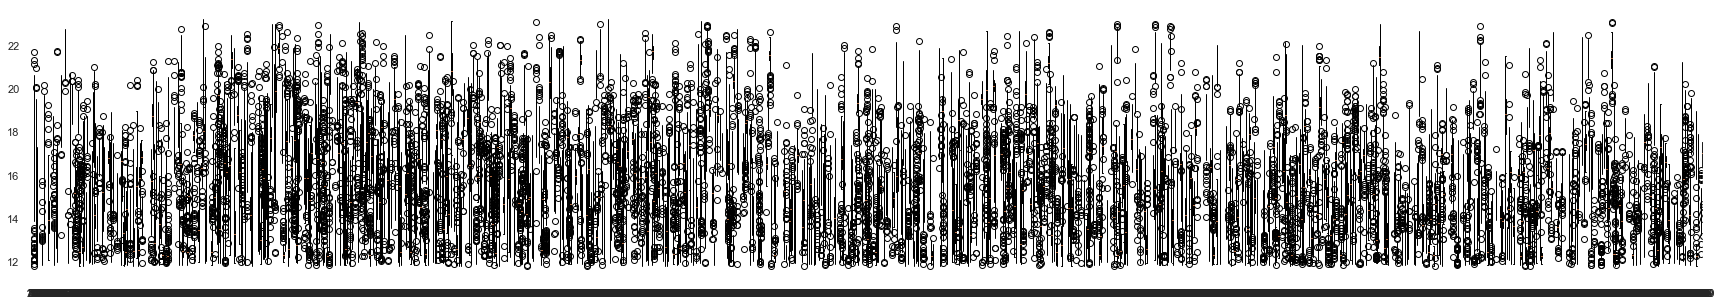

In [11]:
fig, ax = plt.subplots(1,1, figsize=(30, 5))

ax.boxplot(X_)

In [11]:
#Make pipeline
dataPrepPipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ]) 

#X is already purely numerical
X = dataPrepPipe.fit_transform(X_)
X_.shape

(181, 2700)

In [12]:
# Encode target labels
labEnc = preprocessing.LabelEncoder() 
y = labEnc.fit_transform(y_) 
cancerDict = dict(set(zip(y, y_)))
cancerTypes = list(cancerDict.items())
cancerTypes.sort()
cancerTypes


[(0, 'Breast Cancer'),
 (1, 'Colorectal Cancer'),
 (2, 'Healthy'),
 (3, 'Lung Cancer'),
 (4, 'Pancreatic Cancer'),
 (5, 'Prostate Cancer')]

In [43]:
# Save X and y for next session
joblib.dump(y, "Models2/y.pkl")
joblib.dump(X, "Models2/X.pkl")


['Models2/X.pkl']

In [2]:
# load saved X and y 
y = joblib.load("Models2/y.pkl")
X = joblib.load("Models2/X.pkl")


### Part 4: Feature Selection
For the feature selection different appraoches are applied. Furthermore, the results of the feature selection will be visualized. Random Forest and XGBoost is applied for feature selection. Furthermore botch approaches are conduncted once with the scklearn.feature_selection and with sklearn.genetic.GAFeatureSelection

### Random Forest Feature Selection

Original X shape: (181, 2700)
Feature selected X_new shape: (181, 90)


['Models2/featSel_RF.pkl']

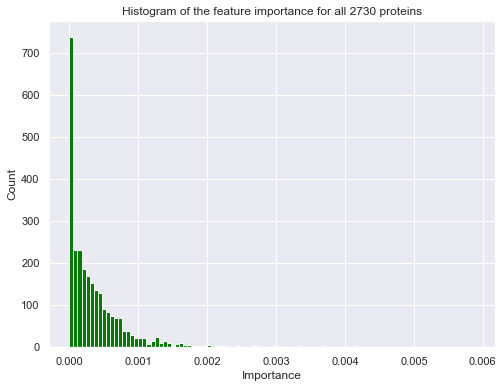

In [13]:
#skleanr.feature_selection
"""
Can be used in pipeline
clf = Pipeline([ 
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
"""
#create Random Forest classifier with random hyperparameters
#params  = {'n_estimators': 114, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 18, 'bootstrap': False}
params = {}
clf_RA  = RandomForestClassifier(random_state=0, **params)
clf_RA.fit(X, y)

#checkout importance in a histogram
plt.figure(figsize=(8,6))
plt.hist(clf_RA.feature_importances_, bins=100, color='green')
plt.title("Histogram of the feature importance for all 2730 proteins")
plt.xlabel("Importance")
plt.ylabel("Count")


#get the reduced X
selector  = SelectFromModel(estimator = clf_RA, prefit=True, max_features=90)
X_RF      = selector.transform(X)

print(f"Original X shape: {X.shape}")
print(f"Feature selected X_new shape: {X_RF.shape}")

joblib.dump(X_RF, "Models2/X_RF.pkl")
joblib.dump(selector.get_support(), "Models2/featSel_RF.pkl")


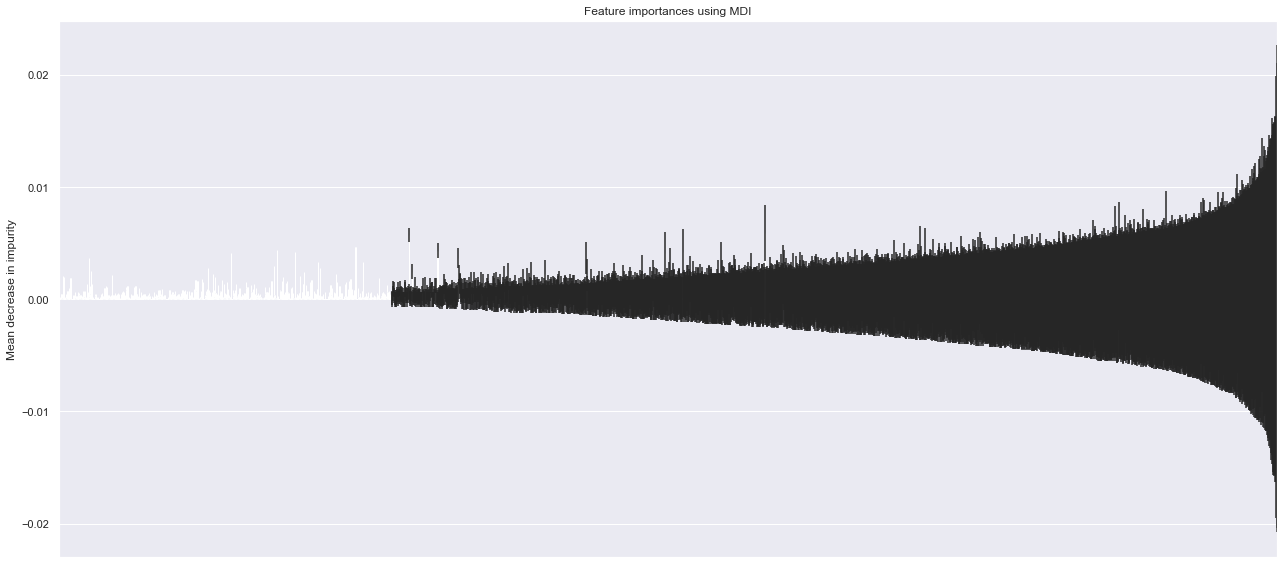

In [14]:
# Visualize feature importance
importances = clf_RA.feature_importances_

std = np.std([tree.feature_importances_ for tree in clf_RA.estimators_], axis=0)
std.sort()

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.get_xaxis().set_visible(False)
fig.tight_layout()
plt.show()


In [17]:
#sklearn_genetic.GAFeatureSelection
#params  = {'n_estimators': 114, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 18, 'bootstrap': False}
params  = {}
clf_RF    = RandomForestClassifier(random_state=0, **params)

evolved_estimator = GAFeatureSelectionCV(
    estimator   = clf_RF,
    cv          = None,
    population_size=20, 
    generations =40,
    crossover_probability=0.8,
    mutation_probability = 0.15,
    n_jobs      = -1,
    scoring     = "accuracy")

# Train and select the features
evolved_estimator.fit(X, y)

# Features selected by the algorithm
X_RFGA    = X[:, evolved_estimator.best_features_]

joblib.dump(X_RFGA, "Models2/X_RFGA.pkl")
joblib.dump(evolved_estimator.best_features_, "Models2/featSel_RFGA.pkl")


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.506727	0.0354284  	0.568619   	0.436637   
1  	38    	0.539324	0.0205726  	0.568619   	0.496847   
2  	38    	0.553116	0.0172043  	0.585736   	0.512913   
3  	37    	0.55533 	0.021556   	0.585736   	0.502252   
4  	38    	0.56506 	0.0140154  	0.590841   	0.546697   
5  	37    	0.573101	0.0126013  	0.590841   	0.546697   
6  	40    	0.571179	0.0143589  	0.590841   	0.541291   


KeyboardInterrupt: 

### XGboost Feature Selection

/Users/jonathanrieder/opt/anaconda3/envs/becs2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "use_labe_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:45:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "use_labe_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Original X shape: (181, 2700)
Feature selected X_new shape: (181, 90)


['Models2/featSel_XG.pkl']

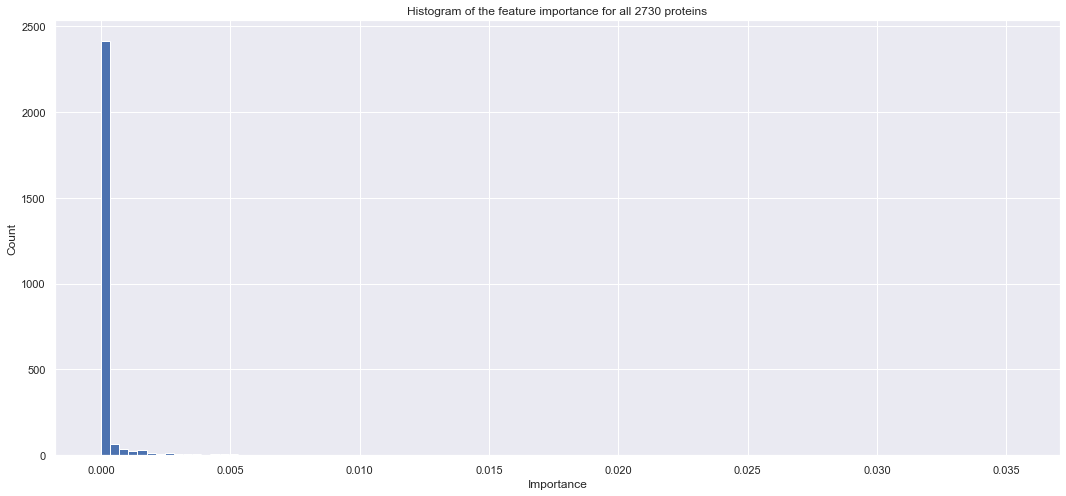

In [15]:
#sklearn.feature_selection
clf_XG = xgboost.XGBClassifier(tree_method='exact',
                            eval_metric='mlogloss',
                            use_labe_encoder=False,
                            random_state=0)
clf_XG.fit(X,y)

#checkout importance in a histogram
plt.hist(clf_XG.feature_importances_, bins=100)
plt.title("Histogram of the feature importance for all 2730 proteins")
plt.xlabel("Importance")
plt.ylabel("Count")

selector = SelectFromModel(estimator = clf_XG, max_features=90)
selector.fit(X,y)

X_XG = selector.transform(X)

print(f"Original X shape: {X.shape}")
print(f"Feature selected X_new shape: {X_XG.shape}")

joblib.dump(X_XG, "Models2/X_XG.pkl")
joblib.dump(selector.get_support(), "Models2/featSel_XG.pkl")

In [56]:
"""import seaborn as sns 

sns.set_theme(style="ticks")

sns.pairplot(X_[:,selector.get_support()] )
"""

TypeError: '(slice(None, None, None), array([ True,  True, False, False, False]))' is an invalid key

In [57]:
#sklearn_gentic.GAFeatureSelection
clf_XG = xgboost.XGBClassifier(tree_method='exact',
                            eval_metric='mlogloss',
                            use_label_encoder=False,
                            random_state=0)
clf_XG.fit(X,y)

evolved_estimator = GAFeatureSelectionCV(
    estimator           = clf_XG,
    cv                  = None,
    population_size     =25, 
    generations         =40,
    crossover_probability=0.8,
    mutation_probability= 0.1,
    n_jobs              = -1,
    scoring             = "accuracy")

# Train and select the features
evolved_estimator.fit(X, y)

#susbet data to only the chosen features
X_XGGA    = X[:, evolved_estimator.best_features_]

joblib.dump(X_XGGA, "Models2/X_XGGA.pkl")
joblib.dump(evolved_estimator.best_features_, "Models2/featSel_XGGA.pkl")


KeyboardInterrupt: 

## Part 5: Model Training
Two different models are applied. First a random forest classifier is used to classify the data and second a XGBoost classifier is applied. Both models run with the features of the klearn_featureselection, hence the feature selection of this module outperformed the sklearn.genetic.GAFeatureSelection.

In [16]:
"""
The different features from part 4 are loaded here to find the optimal set of features for the prediction
"""
featSel_RF = joblib.load("Models2/featSel_RF.pkl")
featSel_RFGA = joblib.load("Models2/featSel_RFGA.pkl")   
featSel_XG = joblib.load("Models2/featSel_XG.pkl")       #<-- WINNER for Xgboost very high for random forest
#featSel_XGGA = joblib.load("Models2/featSel_XGGA.pkl")

cancerTypes = joblib.load("rawData/cancerTypes.pkl")

In [17]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X[:,featSel_XG], y, test_size=0.3, random_state=0)

print(X.shape)
print(X[:,featSel_XG].shape)
print(X_train.shape)

(181, 2700)
(181, 90)
(126, 90)


### Random Forest

In [18]:
#initialize classifier
clf_RF = RandomForestClassifier(random_state=0)
clf_RF.fit(X_train ,y_train)
y_RFpred    = clf_RF.predict(X_test)

print("Accuracy Random Forest:",metrics.accuracy_score(y_test , y_RFpred))
print(classification_report(y_test, y_RFpred, target_names=cancerTypes))

Accuracy Random Forest: 0.7272727272727273
                   precision    recall  f1-score   support

    Breast Cancer       0.55      0.67      0.60         9
Colorectal Cancer       0.75      0.82      0.78        11
          Healthy       0.88      0.78      0.82         9
      Lung Cancer       0.60      0.50      0.55         6
Pancreatic Cancer       0.80      0.80      0.80        10
  Prostate Cancer       0.78      0.70      0.74        10

         accuracy                           0.73        55
        macro avg       0.72      0.71      0.71        55
     weighted avg       0.73      0.73      0.73        55



### XGBoost Classifier

In [19]:
#initialize classifier
clf_XG = xgboost.XGBClassifier(tree_method='exact',
                            eval_metric='mlogloss',
                            use_lable_encoder=False,
                            random_state=0)

clf_XG.fit(X_train ,y_train)
y_XGpred = clf_XG.predict(X_test)

print("Accuracy XGBoost Random Forest:",metrics.accuracy_score(y_test , y_XGpred))
print(classification_report(y_test, y_XGpred, target_names=cancerTypes))

/Users/jonathanrieder/opt/anaconda3/envs/becs2/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "use_lable_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy XGBoost Random Forest: 0.7454545454545455
                   precision    recall  f1-score   support

    Breast Cancer       0.70      0.78      0.74         9
Colorectal Cancer       0.70      0.64      0.67        11
          Healthy       0.89      0.89      0.89         9
      Lung Cancer       0.50      0.50      0.50         6
Pancreatic Cancer       0.73      0.80      0.76        10
  Prostate Cancer       0.89      0.80      0.84        10

         accuracy                           0.75        55
        macro avg       0.73      0.73    

## Part 6: Hyperparameter Tuning
In this chapter the model is optimized by hyperparameter tuning. A random grid search is applied to selected hyperparameters of both models. The hyperparametertuning follows the instructions of the following publication https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 (31.12.21). Hyperparameter tuning needs time and resources. Therefore, after each hyperparameter tuning the model is run with optimized parameters, so hyperparameter tuning is not needed to be run if there is no time for it. Furthermore, be aware that each grid search results in different optimized parameters. We selected the best parameter we obtained by running the grid search several times with different conditions.

In [48]:
#initialize model
clf_RF    = RandomForestClassifier(random_state=0)

#Define hyperparameters for tuning
n_estimators_RF = [x for x in np.linspace(start=100, stop=1000, dtype=int)] #number of trees
criterion_RF    = ['gini', 'entropy'] #function to measure quality of a split
max_depth_RF = [int(x) for x in np.arange(1, 100)] #numbber of levels
max_depth_RF.append(None)
min_samples_split_RF = [int(x) for x in np.arange(2, 30)] #minimum number of samples required to split a note
min_samples_leaf_RF = [np.arange(start=1, stop=5)] #minimum number of samples required at each leaf node
max_features_RF = ['auto', 'sqrt', 'log2'] #number of features
bootstrap_RF = [True, False] #method of selecting samples for training

#initialize random grid with hyperparameters
random_grid_RF = {'n_estimators': n_estimators_RF,
            'criterion'         : criterion_RF,
            'max_features'      : max_features_RF,
            'max_depth'         : max_depth_RF,                        
            'min_samples_split' : min_samples_split_RF,
            'bootstrap'         : bootstrap_RF}

#define model parameters for random grid search
RF_random = RandomizedSearchCV(estimator=clf_RF,
                            param_distributions=random_grid_RF,
                            n_iter=300,
                            cv=15,
                            verbose=2,
                            n_jobs=-1)

#fit the random search model
RF_random.fit(X_train, y_train)

#get best hyperparameters from the model
RF_random.best_params_

Fitting 15 folds for each of 300 candidates, totalling 4500 fits
[CV] END bootstrap=False, criterion=gini, max_depth=22, max_features=log2, min_samples_split=19, n_estimators=485; total time=   1.4s
[CV] END bootstrap=False, criterion=gini, max_depth=22, max_features=log2, min_samples_split=19, n_estimators=485; total time=   1.4s
[CV] END bootstrap=False, criterion=gini, max_depth=22, max_features=log2, min_samples_split=19, n_estimators=485; total time=   1.4s
[CV] END bootstrap=False, criterion=gini, max_depth=22, max_features=log2, min_samples_split=19, n_estimators=485; total time=   1.4s
[CV] END bootstrap=False, criterion=gini, max_depth=22, max_features=log2, min_samples_split=19, n_estimators=485; total time=   1.5s
[CV] END bootstrap=False, criterion=gini, max_depth=22, max_features=log2, min_samples_split=19, n_estimators=485; total time=   1.5s
[CV] END bootstrap=False, criterion=gini, max_depth=22, max_features=log2, min_samples_split=19, n_estimators=485; total time=   1.

{'n_estimators': 632,
 'min_samples_split': 3,
 'max_features': 'sqrt',
 'max_depth': 99,
 'criterion': 'entropy',
 'bootstrap': False}

In [49]:
#run model with optimized hyperparameters

#params = {'n_estimators': 526, 'min_samples_split': 7,'max_features': 'sqrt', 'max_depth': 16, 'criterion': 'entropy','bootstrap': True}
#params  = {'n_estimators': 476, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 17, 'bootstrap': False}  #<-- 0.74 WINNER vo vorher
#params  = {'n_estimators': 460, 'min_samples_split': 7, 'max_features': 'log2', 'max_depth': 9, 'bootstrap': False}  
#params  = {'n_estimators': 600, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}
params  = {'n_estimators': 742, 'min_samples_split': 8, 'max_features': 'log2', 'max_depth': 62, 'bootstrap': True, 'criterion': 'gini'}

clf_RF_tuned = RandomForestClassifier(**params, random_state = 2)

clf_RF_tuned.fit(X_train ,y_train)
y_RFpred_tuned = clf_RF_tuned.predict(X_test)

print("Accuracy Random Forest with tuned hyperparameters:",metrics.accuracy_score(y_test , y_RFpred_tuned))
print(classification_report(y_test, y_RFpred_tuned, target_names=cancerTypes))

Accuracy Random Forest with tuned hyperparameters: 0.6363636363636364
                   precision    recall  f1-score   support

    Breast Cancer       0.45      0.56      0.50         9
Colorectal Cancer       0.58      0.64      0.61        11
          Healthy       0.75      0.67      0.71         9
      Lung Cancer       0.45      0.83      0.59         6
Pancreatic Cancer       0.86      0.60      0.71        10
  Prostate Cancer       1.00      0.60      0.75        10

         accuracy                           0.64        55
        macro avg       0.68      0.65      0.64        55
     weighted avg       0.70      0.64      0.65        55



In [119]:
#initialize model
clf_XG = xgboost.XGBClassifier(use_label_encoder = False, eval_metric = ['mlogloss'])

#Define hyperparameters for tuning
eta_XGRF = [x for x in np.linspace(start=0.01, stop=0.75, num=20)]
gamma_XGRF = [x for x in np.linspace(start=0, stop=5, num=10)] #min split los
max_depth_XGRF = [x for x in np.arange(0, 30, step=2)] #numbber of levels
min_child_weight_XGRF = [x for x in np.linspace(start=0, stop=20, num=10)]
max_delta_step_XGRF = [x for x in np.linspace(start=0, stop=20, num=10)]
subsample_XGRF = [x for x in np.linspace(start=0.1, stop=1.0, num=5)]
colsample_bytree_XGRF = [x for x in np.linspace(start=0.1, stop=1, num=5)]
reg_lambda_XGRF = [int(x) for x in np.arange(start=1, stop=10)] #min split los
tree_method_XGRF = ['auto', 'approx', 'hist', 'gpu_hist']
refresh_leaf_XGRF = [1, 0]
max_bin_XGRF = [x for x in np.linspace(start=100, stop=500, num=20, dtype=int)]

random_grid_XGRF = {'eta'           : eta_XGRF,
                'gamma'             : gamma_XGRF,
                'max_depth'         : max_depth_XGRF,
                'min_child_weight'  : min_child_weight_XGRF,
                'max_delta_step'    : max_delta_step_XGRF,
                'subsample_XGRF'    : subsample_XGRF,
                'colsample_bytree'  : colsample_bytree_XGRF,
                'reg_lambda'        : reg_lambda_XGRF,
                'tree_method'       : tree_method_XGRF,
                'refresh_leaf'      : refresh_leaf_XGRF,
                'max_bin'           : max_bin_XGRF}


#define model parameters for random grid search
XGRF_random = RandomizedSearchCV(estimator = clf_XG,
                        param_distributions =random_grid_XGRF,
                        n_iter=100,
                        cv=5,
                        verbose=0,
                        n_jobs=-1)

#fit the random search model
XGRF_random.fit(X_train, y_train)

#get best hyperparameters from the model
XGRF_random.best_params_

OverflowError: Python int too large to convert to C long

In [28]:
#run model with optimized hyperparameters

params  = {'tree_method': 'auto',
 'subsample': 1.0,
 'reg_lambda': 1,
 'refresh_leaf': 0,
 'min_child_weight': 8.88888888888889,
 'max_depth': 8,
 'max_delta_step': 2.2222222222222223,
 'max_bin': 268,
 'gamma': 2.2222222222222223,
 'colsample_bytree': 0.775}

clf_XG_tuned = xgboost.XGBClassifier(random_state=0, use_label_encoder = False, eval_metric = ['mlogloss'])

clf_XG_tuned.fit(X_train ,y_train)
y_XGpred_tuned = clf_XG_tuned.predict(X_test)

print("Accuracy XGBoost with tuned hyperparameters:",metrics.accuracy_score(y_test , y_XGpred_tuned))
print(classification_report(y_test, y_XGpred_tuned, target_names=cancerTypes))

Accuracy XGBoost with tuned hyperparameters: 0.7454545454545455
                   precision    recall  f1-score   support

    Breast Cancer       0.70      0.78      0.74         9
Colorectal Cancer       0.70      0.64      0.67        11
          Healthy       0.89      0.89      0.89         9
      Lung Cancer       0.50      0.50      0.50         6
Pancreatic Cancer       0.73      0.80      0.76        10
  Prostate Cancer       0.89      0.80      0.84        10

         accuracy                           0.75        55
        macro avg       0.73      0.73      0.73        55
     weighted avg       0.75      0.75      0.75        55



## Part 7: Model Validation

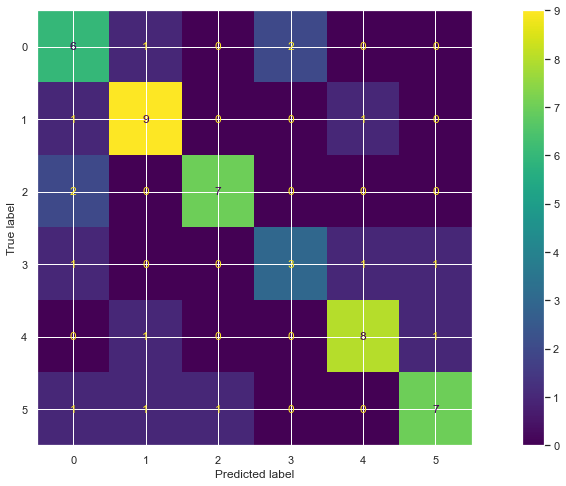

In [29]:
# visualize confusion matrix

cm = confusion_matrix(y_test, y_RFpred, labels=clf_RF.classes_) # calculate value
disp = ConfusionMatrixDisplay(confusion_matrix=cm,              # display
                              display_labels=clf_RF.classes_)
disp.plot(); 



### Compare uncertainty of Data and Model

In [30]:
params  = {'n_estimators': 476, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 17, 'bootstrap': False} 

clf_RF_val = RandomForestClassifier(**params, random_state = 0)

scores = cross_val_score(clf_RF_val, X_train, y_train, cv=5, scoring='accuracy')
Udata = scores.std()

modAcuRF = []
for rs in range(1,6):
    clf_RF_val2 = RandomForestClassifier(**params, random_state = random.randrange(rs))
    clf_RF_val2.fit(X_train, y_train)
    modAcuRF += [accuracy_score(y_test, clf_RF_val2.predict(X_test))]

Umodel = np.std(modAcuRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

Uncertainty in the data: 0.065
Uncertainty in the model: 0.036
The model performance is 0.659 ± 0.065 ± 0.036


In [31]:
params  = {'tree_method': 'auto',
 'subsample': 1.0,
 'reg_lambda': 1,
 'refresh_leaf': 0,
 'min_child_weight': 8.88888888888889,
 'max_depth': 8,
 'max_delta_step': 2.2222222222222223,
 'max_bin': 268,
 'gamma': 2.2222222222222223,
 'colsample_bytree': 0.775}

clf_XG_tuned = xgboost.XGBClassifier(random_state=0, **params, use_label_encoder = False, eval_metric = ['mlogloss'])

scores = cross_val_score(clf_XG_tuned, X_train, y_train, cv=5, scoring='accuracy')
Udata = scores.std()

modAcuXGRF = []
for rs in range(1,6):
    model = xgboost.XGBClassifier(random_state=random.randrange(rs), **params, use_label_encoder = False, eval_metric = ['mlogloss'])
    model.fit(X_train, y_train)
    modAcuXGRF += [accuracy_score(y_test, model.predict(X_test))]

Umodel = np.std(modAcuXGRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

Uncertainty in the data: 0.077
Uncertainty in the model: 0.007
The model performance is 0.468 ± 0.077 ± 0.007


### Receiver Operating Characteristic (ROC)

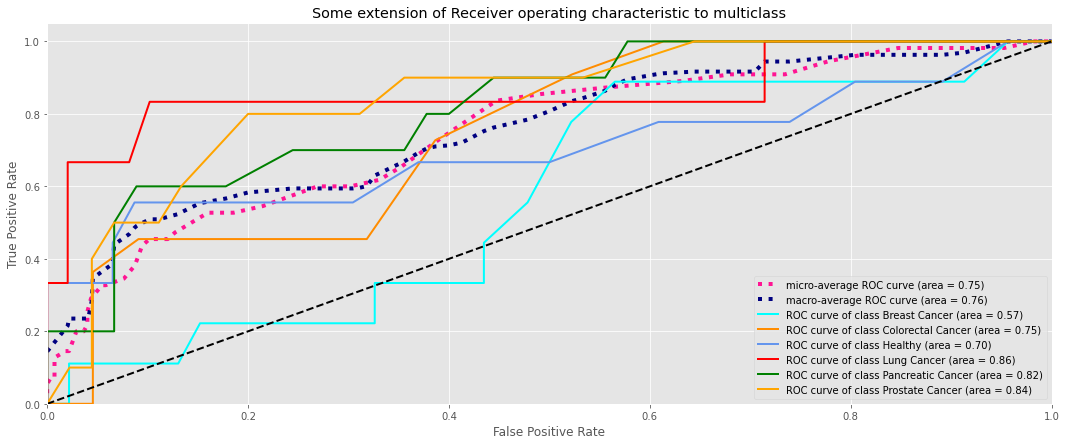

In [11]:

from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

n_classes = 6
X
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#params  = {'n_estimators': 476, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 17, 'bootstrap': False}
params = {}
# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    RandomForestClassifier(**params, random_state = 0)
)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

lw = 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(18,7))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "orange"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(cancerTypes[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## Model explainability

### Using the package eli5

#### As can be seen from the first entry P05186 = Alkaline phosphatase this is a known biomarker for the following cancer: https://glygen.org/protein/P05186#
* colorectral cancer
* breast cancer
* lung cancer

#### or second entry Q01995 = Transgelin (https://research.bioinformatics.udel.edu/iptmnet/entry/Q01995/)
* lung cancer
* melanoma


In [64]:
import eli5

clf_RF_tuned = RandomForestClassifier(**params, random_state = 2)

clf_RF_tuned.fit(X_train ,y_train)

eli5.show_weights(clf_RF_tuned, feature_names=X_.iloc[:, featSel_XG].columns.tolist())


Weight,Feature
0.0397 ± 0.0881,P05186
0.0388 ± 0.0827,Q01995
0.0378 ± 0.0795,P20742
0.0324 ± 0.0867,P07288
0.0294 ± 0.0796,P41159
0.0223 ± 0.0719,Q5VVQ6
0.0216 ± 0.0673,O95967
0.0201 ± 0.0670,P15144
0.0179 ± 0.0562,P55899
0.0179 ± 0.0604,Q6Q788


In [69]:
eli5.sklearn.explain_prediction_tree_classifier(estimator = clf_RF_tuned, feature_names=X_.iloc[:, featSel_XG].columns.tolist())

AttributeError: module 'eli5.sklearn' has no attribute 'explain_prediction_tree_classifier'

In [67]:
X_train[1].shape

(90,)

### Discussion and Outlook
The aim of this project work was to classify patient’s health status according to their corresponding protein fingerprints. As the code shows two different classifiers (Random Forest and XGBoost) had been implemented successfully to predict a patient’s health status with an accuracy over 70 %. However, due to limiting factors for example time or computing powers of our laptops, the full potential of the code is not yet achieved. As we can see the hyperparameter tuning for the XGBoost did not result in an increased accuracy, meaning that the default parameters are better or the same as the ones proposed by the random grid search. Hyperparameter tuning is time and resource intensive, with more hyperparameters it will take longer to find the optimal combinations and more computing power will be needed. Especially, fine tuning the XGBoost with its different and numerous parameters is difficult. Never less, it should be further investigated because it will make the code more reliable. In addition, different methods for finding optimal parameters are recommended. Another important aspect of this project is its future selection. The number of proteins for each patient is high and for sure some of them are more important than other ones. In this project who different feature selection algorithms had been applied. As the results show the performance differs significantly. In the future, further methods should be conducted to find the best features. In general once must trust in the algorithm that the optimal features will be selected. Having said this, the exact execution of the algorithm is not known (black box). With more adjustable approaches and project specific feature selection the overall performance of the code could be improved further. Overall, this works shows that digital approaches can be beneficial in the determination of cancer diagnosis. Computer based analysis have a major potential and with further improvements and adjustments of the code the usability will continuously improve. With the right settings code like this will be a helpful tool for specialists to classify diseases and help to find effective treatments.